In [18]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd 
import rasterio 
from rasterio.plot import  show, adjust_band
from rasterio.mask import mask
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings 
from os import listdir
from visualisation_scripts import get_maps, for_field_ploting, for_point_ploting
from datetime import datetime as dt

warnings = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Подготовка данных

In [19]:
archangelskiy = pd.read_csv('points_gps/arch_crc.csv', encoding=  'ANSI', sep = ';')


archangelskiy = pd.read_csv('points_gps/arch_crc.csv', encoding=  'ANSI', sep = ';')

archangelskiy['вес'] =archangelskiy['вес'] - archangelskiy['тара']
archangelskiy['вес [ц/га]'] = archangelskiy['вес'] * 4 * (10000) / 1000 / 100 # переход в Ц/Га
archangelskiy = archangelskiy[['точка', '%', 'вес [ц/га]']]
archangelskiy = archangelskiy.groupby('точка').mean().reset_index()
archangelskiy.columns = ['type', 'perc [%] полевой',"вес [ц/га] полевой" ]

archangelskiy_cameral = pd.read_csv('points_gps/cameral_crc.csv', encoding = "ANSI", sep =';')
archangelskiy_cameral = archangelskiy_cameral[['name', '%']].groupby('name').mean().reset_index()
archangelskiy_cameral.columns = ['type' , 'perc [%] камеральный']


archangelskiy = archangelskiy.merge(archangelskiy_cameral, on = 'type', how = 'outer')
archangelskiy

,type,perc [%] полевой,вес [ц/га] полевой,perc [%] камеральный
0,525,62.50,21.4,82.000000
1,526,81.25,41.5,89.714286
2,527,68.75,32.5,96.857143
3,528,68.75,24.0,80.285714
4,586,96.75,62.4,87.142857
5,587,43.75,38.9,30.000000
6,588,33.75,27.4,30.571429


#### точки

In [20]:
archangelskiy_points = gpd.read_file('points_gps/arch_points.geojson')[['name', 'geometry']]
archangelskiy_points.columns = ['type',"geometry" ]
archangelskiy_points

,type,geometry
0,525,POINT Z (44.18418 44.55136 170.78041)
1,526,POINT Z (44.18086 44.54805 167.81140)
2,527,POINT Z (44.17407 44.54223 164.98230)
3,528,POINT Z (44.16865 44.54459 169.67947)
4,529,POINT Z (44.16700 44.53811 175.87118)
5,585,POINT Z (44.16801 44.53532 172.00731)
6,586,POINT Z (44.17582 44.54182 160.97470)
7,587,POINT Z (44.18650 44.54988 162.74657)
8,588,POINT Z (44.18876 44.54880 163.77283)
9,584,POINT Z (44.16901 44.53682 0.00000)


#### Пример растра и его выходные данные

In [21]:
Raster_at_moment = rasterio.open('raster_data/Field_scale_sentinel2_2021-09-21_scene.tif')
NDVI_at_moment_array = Raster_at_moment.read()[6]
NDTI_at_monent_array = Raster_at_moment.read()[7]

NDTI = NDTI_at_monent_array.copy()
NDTI[NDVI_at_moment_array >= 0.3] = np.nan #маска

NDVI_mask = (NDVI_at_moment_array >= 0.3).astype('int')

metadata = Raster_at_moment.meta

metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 369,
 'height': 401,
 'count': 8,
 'crs': CRS.from_epsg(32638),
 'transform': Affine(10.0, 0.0, 432290.0,
        0.0, -10.0, 4934320.0)}

#### Визуализация растра

[Text(0.5, 1.0, 'NDTI 2021-09-21 \n(на момент проведения полевых работ)')]

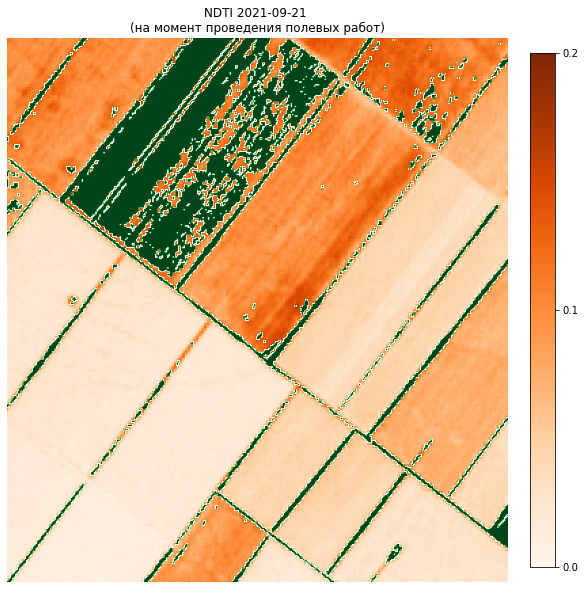

In [22]:
fig, axes = plt.subplots( figsize=(10,10)) 

NDTI_hiden_layer = axes.imshow(NDVI_mask, cmap='Greens')
NDTI_vis = axes.imshow(NDTI, cmap='Oranges')
NDTI_vis.set_clim(vmin = 0 , vmax = 0.2)
fig.colorbar(NDTI_vis, fraction=0.046, pad=0.04, ax=axes).set_ticks([ 0,0.1,0.2])
axes.axis('off')
axes.set(title = 'NDTI 2021-09-21 \n(на момент проведения полевых работ)')



#### Формула для теоретического расчета растительных остатков

In [23]:

def RC_cover(x):
    rc = (m * x) + b 
    return(rc)


NDTI_arr = NDTI.reshape(-1)
NDTI_arr = NDTI_arr[~np.isnan(NDTI_arr)]
top = NDTI_arr.mean() + (3 * NDTI_arr.std())
bottom = NDTI_arr.mean() - (3 * NDTI_arr.std())
m = (0.85 - 0)/(top - bottom)
b = -1 * (m * bottom)

imperic_crc_std_method = RC_cover(NDTI)




In [24]:
rasters_dict = {'NDTI в моменте' : NDTI,
                "имперический NDTI +-3 стнд.откл" : imperic_crc_std_method
}


def extract_values_to_points(raster,points_df):
    X_ = points_df.to_crs(metadata['crs']).geometry.x
    Y_ = points_df.to_crs(metadata['crs']).geometry.y
    points_dict ={}
    for i in range(len(points_df['type'])):
        ind = (Raster_at_moment.index(X_[i],Y_[i]))
        points_dict[points_df['type'][i]] = raster[ind[0], ind[1]]
    df = pd.DataFrame.from_dict(points_dict, orient='index',).reset_index()
    return(df)

for method in rasters_dict.keys():
    df = extract_values_to_points(rasters_dict[method],archangelskiy_points)
    df.columns = ["type", method]
    df['type'] = df['type'].astype('int64')
    archangelskiy = archangelskiy.merge(df, on = 'type', how = 'outer')

archangelskiy = archangelskiy.fillna(value = 0)

archangelskiy

,type,perc [%] полевой,вес [ц/га] полевой,perc [%] камеральный,NDTI в моменте,имперический NDTI +-3 стнд.откл
0,525,62.50,21.4,82.000000,0.121709,0.652407
1,526,81.25,41.5,89.714286,0.115793,0.630413
2,527,68.75,32.5,96.857143,0.130336,0.684481
3,528,68.75,24.0,80.285714,0.099462,0.569697
4,586,96.75,62.4,87.142857,0.131532,0.688926
5,587,43.75,38.9,30.000000,0.049634,0.384444
6,588,33.75,27.4,30.571429,0.039044,0.345074
7,529,0.00,0.0,0.000000,0.022754,0.284511
8,585,0.00,0.0,0.000000,0.019031,0.270667
9,584,0.00,0.0,0.000000,0.024867,0.292365


In [25]:
#в данные приелетела точка 584, а в начале я ее не брал в данные 
archangelskiy = archangelskiy[archangelskiy["type"] != 584]

In [26]:
archangelskiy

,type,perc [%] полевой,вес [ц/га] полевой,perc [%] камеральный,NDTI в моменте,имперический NDTI +-3 стнд.откл
0,525,62.50,21.4,82.000000,0.121709,0.652407
1,526,81.25,41.5,89.714286,0.115793,0.630413
2,527,68.75,32.5,96.857143,0.130336,0.684481
3,528,68.75,24.0,80.285714,0.099462,0.569697
4,586,96.75,62.4,87.142857,0.131532,0.688926
5,587,43.75,38.9,30.000000,0.049634,0.384444
6,588,33.75,27.4,30.571429,0.039044,0.345074
7,529,0.00,0.0,0.000000,0.022754,0.284511
8,585,0.00,0.0,0.000000,0.019031,0.270667


## Моделирование данных

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score 
from sklearn.model_selection import LeaveOneOut as LOO #кросс валидация leave one out

Модель, которая на выход дает значения

In [28]:
def line_regression(df):
    """
    на вход df с двумя колонками - 1я по чему учимся, 2я полевые значения
    на выход 
    fig -  граффик
    model - уже обученная модель 
    R2 - коэффициент детерминации
    RMSE -корень средний квадрат ошибки
    """
    litle_df = df.copy()
    X = litle_df.iloc[:,0].values.reshape(-1,1)
    y = litle_df.iloc[:,1].values.reshape(-1,1)


    
    model = LinearRegression()
    model.fit(X ,y)
    Y_ = model.predict(X)
    litle_df['predicted'] = Y_

    R2 = round(model.score(X,y) , 2) #коэф детерминации
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error',
                         cv=loo, n_jobs=-1)
    RMSE = round(np.mean(abs(scores)),2) # RMSE

    coef = round(model.coef_[0][0] , 2)
    intecept = round(model.intercept_[0],2)
    if str(intecept)[0] == '-':
        sign = ''
    else:
        sign = '+'
    return({"модель" : model,
            'предиктор' :  coef,
            'интерсепт' : (sign + str(intecept) ),
            'R2' : R2,
            "RMSE" : RMSE,
            'предсказания' : Y_
    })

In [29]:
model1 =  line_regression(archangelskiy[["NDTI в моменте","perc [%] полевой" ]]) #NDTI в момент полевых работ и полевые данные о площади покрытия
model3 =  line_regression(archangelskiy[["NDTI в моменте","perc [%] камеральный" ]]) #NDTI в момент полевых работ и камеральные данные о площади покрытия

### NDTI в моменте"/"perc [%] полевой

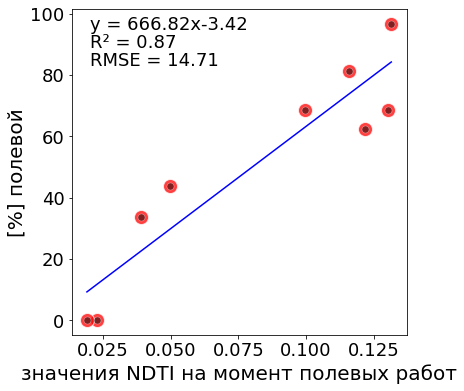

In [30]:

sns.set_context( rc={"font.size":14,"axes.titlesize":20,"axes.labelsize":20})   
model1 =  line_regression(archangelskiy[["NDTI в моменте","perc [%] полевой" ]]) #NDTI в момент полевых работ и полевые данные о площади покрытия

litle_df = archangelskiy[["NDTI в моменте","perc [%] полевой" ]].copy()

predictions = np.array(model1['предсказания']).reshape(-1)
rmse = model1["RMSE"]
R2 = model1["R2"]

intercept = model1["интерсепт"]
predictor = model1["предиктор"]


fig , axes = plt.subplots(1,1, figsize=(6,6)) 
plot = sns.scatterplot(x = litle_df.iloc[:,0] , y = litle_df.iloc[:,1], color = 'red',s = 200,alpha = 0.75, ax = axes)
plot = sns.scatterplot(x = litle_df.iloc[:,0] , y = litle_df.iloc[:,1], color = 'black',s = 50,alpha = 0.5, ax = axes)

plot = sns.lineplot(x = litle_df.iloc[:,0],y =  predictions , color = 'blue', ax = axes)
axes.text(0.02, 95, f"y = {predictor}x{intercept}", horizontalalignment='left', size=18, color='black')
axes.text(0.02, 89, f"R\u00b2 = {R2}" , horizontalalignment='left', size=18, color='black')
axes.text(0.02, 83, f"RMSE = {rmse}" , horizontalalignment='left', size=18, color='black')
axes.set(xlabel='значения NDTI на момент полевых работ', ylabel = "[%] полевой")
axes.tick_params(labelsize = 18)

### NDTI в моменте/perc [%] камеральный

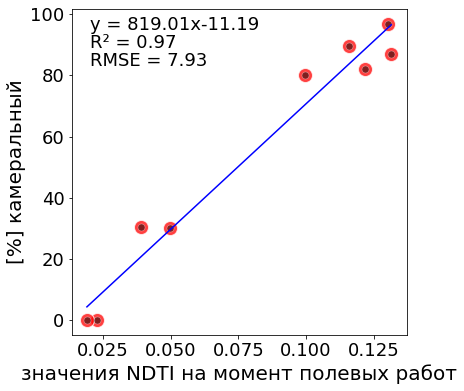

In [31]:
model3 =  line_regression(archangelskiy[["NDTI в моменте","perc [%] камеральный" ]]) #NDTI в момент полевых работ и камеральные данные о площади покрытия

litle_df = archangelskiy[["NDTI в моменте","perc [%] камеральный" ]].copy()

predictions = np.array(model3['предсказания']).reshape(-1)
rmse = model3["RMSE"]
R2 = model3["R2"]

intercept = model3["интерсепт"]
predictor = model3["предиктор"]


fig , axes = plt.subplots(1,1, figsize=(6,6)) 
plot = sns.scatterplot(x = litle_df.iloc[:,0] , y = litle_df.iloc[:,1], color = 'red',s = 200,alpha = 0.75, ax = axes)
plot = sns.scatterplot(x = litle_df.iloc[:,0] , y = litle_df.iloc[:,1], color = 'black',s = 50,alpha = 0.5, ax = axes)

plot = sns.lineplot(x = litle_df.iloc[:,0],y =  predictions , color = 'blue', ax = axes)
axes.text(0.02, 95, f"y = {predictor}x{intercept}", horizontalalignment='left', size=18, color='black')
axes.text(0.02, 89, f"R\u00b2 = {R2}" , horizontalalignment='left', size=18, color='black')
axes.text(0.02, 83, f"RMSE = {rmse}" , horizontalalignment='left', size=18, color='black')
axes.set(xlabel='значения NDTI на момент полевых работ', ylabel = "[%] камеральный")
axes.tick_params(labelsize = 18)


### имперический NDTI +-3 стнд.откл/"perc [%] камеральный"

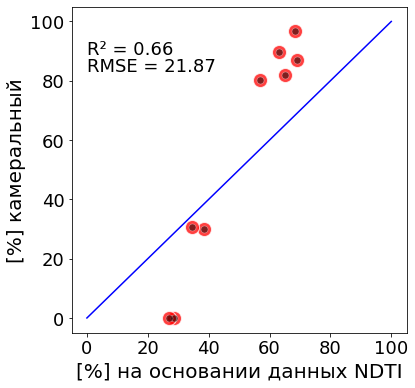

In [32]:
x = archangelskiy["имперический NDTI +-3 стнд.откл"] * 100
y = archangelskiy["perc [%] камеральный"]
rmse = round(np.sqrt(MSE(y, x)), 2)
R2 = round(r2_score(y, x), 2)
fig , axes = plt.subplots(1,1, figsize=(6,6)) 

plot = sns.scatterplot(x = x, y = y, color = 'red',s = 200,alpha = 0.75, ax = axes)
plot = sns.scatterplot(x = x, y = y, color = 'black',s = 50,alpha = 0.5, ax = axes)

plot = sns.lineplot(x = [0,10,20,30, 100], y = [0,10,20,30, 100], color = 'blue', ax = axes)
axes.text(0.02, 89, f"R\u00b2 = {R2}" , horizontalalignment='left', size=18, color='black')
axes.text(0.02, 83, f"RMSE = {rmse}" , horizontalalignment='left', size=18, color='black')
axes.set(xlabel='[%] на основании данных NDTI', ylabel = "[%] камеральный")
axes.tick_params(labelsize = 18)

### имперический NDTI +-3 стнд.откл/perc [%] полевой

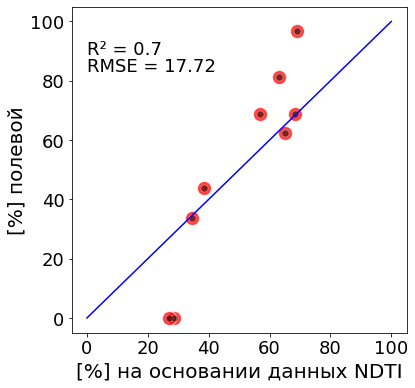

In [33]:
x = archangelskiy["имперический NDTI +-3 стнд.откл"] * 100
y = archangelskiy["perc [%] полевой"]
rmse = round(np.sqrt(MSE(y, x)), 2)
R2 = round(r2_score(y, x), 2)
fig , axes = plt.subplots(1,1, figsize=(6,6)) 

plot = sns.scatterplot(x = x, y = y, color = 'red',s = 200,alpha = 0.75, ax = axes)
plot = sns.scatterplot(x = x, y = y, color = 'black',s = 50,alpha = 0.5, ax = axes)

plot = sns.lineplot(x = [0,10,20,30, 100], y = [0,10,20,30, 100], color = 'blue', ax = axes)
axes.text(0.02, 89, f"R\u00b2 = {R2}" , horizontalalignment='left', size=18, color='black')
axes.text(0.02, 83, f"RMSE = {rmse}" , horizontalalignment='left', size=18, color='black')
axes.set(xlabel='[%] на основании данных NDTI', ylabel = "[%] полевой")
axes.tick_params(labelsize = 18)

## Обработка растров на основании полученной модели

In [34]:
"""
Так как уже все скачано и обработано этот шаг можно пропустить
ИНАЧЕ ПРИДЕТСЯ ПО НОВОЙ ВРУЧНУЮ ЧИСТИТЬ ДАННЫЕ!!!!!!!!! 
rasters = listdir("raster_data/for_modeling")

for raster in rasters:
    
    #Обработка растров в полученной модели
    
    file_name = "raster_data/for_modeling/" + raster
    raster_for_classify = rasterio.open(file_name) 


    metadata = raster_for_classify.meta
    metadata['count'] = 2

    raster_shape = raster_for_classify.read()[6].shape

    NDVI = raster_for_classify.read()[6]
    NDTI = raster_for_classify.read()[7]

    NDTI[NDVI >= 0.3] = 0 #создание маски для NDVI

    predicted = model3['модель'].predict(NDTI.reshape(-1, 1)).T
    CRC = predicted.reshape(raster_shape).astype('float32')
    CRC[CRC >= 100] = 100
    CRC[CRC <= 0] = 0


    ready_img = np.array([NDVI,CRC ])

    new_dataset = rasterio.open(f"raster_data/CRC/CRC{raster}", 'w', **metadata)
    new_dataset.write(ready_img)
    new_dataset.close()
CRC_rasters_dirs = listdir("raster_data/CRC")

archangelskiy_points_reprojected = archangelskiy_points.to_crs(metadata["crs"])
archangelskiy_points_reprojected.geometry =  archangelskiy_points_reprojected.buffer(distance  = 75)
def get_values(raster, geometry):
    
    #на вход растер (в данном случае канал 0 - NDVI  канал 1 - CRC)
    #geometry - geopandas фаил где type - имя обьекта 
    

    point_df = pd.DataFrame()
    date = raster.name.split("/")[-1]
    date = date.split('_')[3]

    unique_objects = geometry['type'].unique()
    for objects in unique_objects:

        litle_df = pd.DataFrame()
        geo = geometry[geometry['type'] == objects]
        arr, _ = mask(raster , shapes = geo.geometry.geometry, nodata=-10 )

        NDVI_arr = arr[0].reshape(-1) #массив NDVI
        NDVI_arr = NDVI_arr[NDVI_arr != -10]
        

        CRC_arr = arr[1].reshape(-1) #массив CRC 
        CRC_arr = CRC_arr[CRC_arr !=-10]
        

        
        litle_df['NDV_values'] = NDVI_arr
        litle_df['CRC_values'] = CRC_arr
        litle_df["date"] = date
        litle_df['type'] = objects
        litle_df = litle_df.sample(n = 10, random_state= 14)

        point_df = point_df.append(litle_df)
    
    return(point_df)
"""

'\nТак как уже все скачано и обработано этот шаг можно пропустить\nИНАЧЕ ПРИДЕТСЯ ПО НОВОЙ ВРУЧНУЮ ЧИСТИТЬ ДАННЫЕ!!!!!!!!! \nrasters = listdir("raster_data/for_modeling")\n\nfor raster in rasters:\n    \n    #Обработка растров в полученной модели\n    \n    file_name = "raster_data/for_modeling/" + raster\n    raster_for_classify = rasterio.open(file_name) \n\n\n    metadata = raster_for_classify.meta\n    metadata[\'count\'] = 2\n\n    raster_shape = raster_for_classify.read()[6].shape\n\n    NDVI = raster_for_classify.read()[6]\n    NDTI = raster_for_classify.read()[7]\n\n    NDTI[NDVI >= 0.3] = 0 #создание маски для NDVI\n\n    predicted = model3[\'модель\'].predict(NDTI.reshape(-1, 1)).T\n    CRC = predicted.reshape(raster_shape).astype(\'float32\')\n    CRC[CRC >= 100] = 100\n    CRC[CRC <= 0] = 0\n\n\n    ready_img = np.array([NDVI,CRC ])\n\n    new_dataset = rasterio.open(f"raster_data/CRC/CRC{raster}", \'w\', **metadata)\n    new_dataset.write(ready_img)\n    new_dataset.close(

In [35]:
def get_values(raster, geometry):
    
    #на вход растер (в данном случае канал 0 - NDVI  канал 1 - CRC)
    #geometry - geopandas фаил где type - имя обьекта 
    

    point_df = pd.DataFrame()
    date = raster.name.split("/")[-1]
    date = date.split('_')[3]

    unique_objects = geometry['type'].unique()
    for objects in unique_objects:

        litle_df = pd.DataFrame()
        geo = geometry[geometry['type'] == objects]
        arr, _ = mask(raster , shapes = geo.geometry.geometry, nodata=-10 )

        NDVI_arr = arr[0].reshape(-1) #массив NDVI
        NDVI_arr = NDVI_arr[NDVI_arr != -10]
        

        CRC_arr = arr[1].reshape(-1) #массив CRC 
        CRC_arr = CRC_arr[CRC_arr !=-10]
        

        
        litle_df['NDV_values'] = NDVI_arr
        litle_df['CRC_values'] = CRC_arr
        litle_df["date"] = date
        litle_df['type'] = objects
        litle_df = litle_df.sample(n = 10, random_state= 14)

        point_df = point_df.append(litle_df)
    
    return(point_df)


In [36]:
# по полям 
CRC_rasters_dirs = listdir("raster_data/CRC")

tree_fields = gpd.read_file('points_gps/3fields.geojson')
tree_fields = tree_fields.to_crs(metadata['crs'])
result_fields_df = pd.DataFrame()
for rast  in CRC_rasters_dirs:
    raster_dir = "raster_data/CRC/" + rast
    raster = rasterio.open(raster_dir)
    one_date_df = get_values(raster , tree_fields)
    result_fields_df = result_fields_df.append(one_date_df)
    
# result_fields_df датафрейм с данными по полям 

result_fields_df = result_fields_df.drop_duplicates()
result_fields_df['date'] = pd.to_datetime(result_fields_df['date'] )
result_fields_df["CRC_values"][result_fields_df['NDV_values'] > 0.3] = np.NaN


c:\Users\ermolaevNR\.conda\envs\GIS3.6\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
archangelskiy_points = gpd.read_file('points_gps/arch_points.geojson')[['name', 'geometry']]
archangelskiy_points.columns = ['type',"geometry" ]

PP_points = ['525', "526", '527', '528', "586"]
only_pp_points = archangelskiy_points[archangelskiy_points['type'].isin(PP_points)]

only_pp_points = only_pp_points.to_crs(metadata['crs'])
only_pp_points["geometry"] = only_pp_points.buffer(50) # буфер 50 метров 


result_points_df = pd.DataFrame()

for rast  in CRC_rasters_dirs:
    raster_dir = "raster_data/CRC/" + rast
    raster = rasterio.open(raster_dir)
    one_date_df = get_values(raster , only_pp_points)
    result_points_df = result_points_df.append(one_date_df)

result_points_df = result_points_df.drop_duplicates()
result_points_df['date'] = pd.to_datetime(result_points_df['date'] )
result_points_df["CRC_values"][result_points_df['NDV_values'] > 0.3] = np.NaN

c:\Users\ermolaevNR\.conda\envs\GIS3.6\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
df = result_fields_df[(result_fields_df['date'] > f"{2020}-11-15") & (result_fields_df['date'] < f"{(2021+1)}-11-15" )]
len(df.date.unique())

14

d:\python_projects\CRC_modeling\visualisation_scripts.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(labels = ['','','',0,25,50,75,100])
d:\python_projects\CRC_modeling\visualisation_scripts.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(labels = ['','','',0,25,50,75,100])


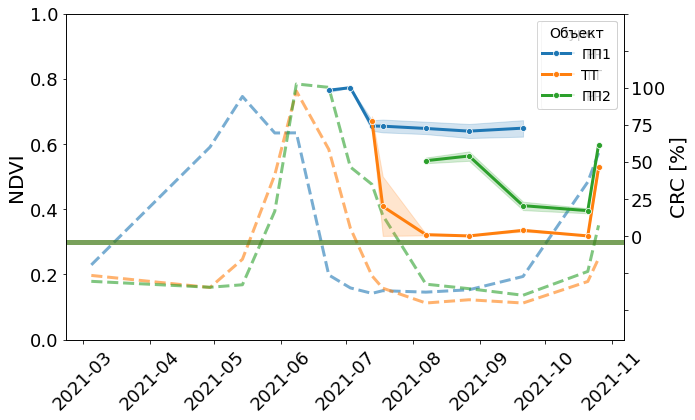

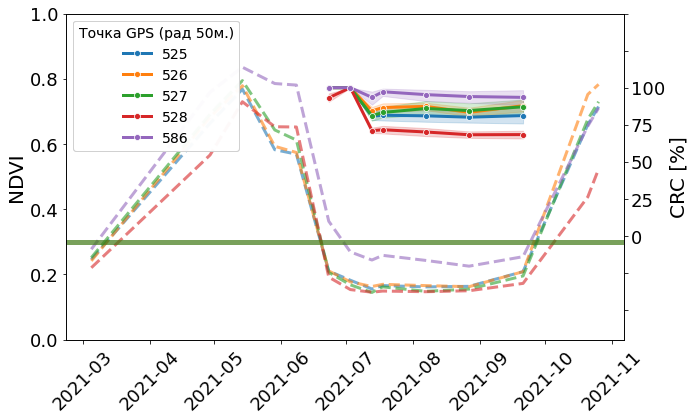

In [39]:
for_field_ploting(2020, result_fields_df)
for_point_ploting(2020, result_points_df)

Статистическое тестироване

In [40]:
from scipy.stats import kruskal

In [41]:
data_2021 = result_points_df[(result_points_df['date'] > "2021-07-05") & (result_points_df['date'] < "2021-10-21" )]
data_2021

,NDV_values,CRC_values,date,type
29,0.142182,76.019119,2021-07-13,525
35,0.159057,83.177261,2021-07-13,525
44,0.154887,84.711273,2021-07-13,525
6,0.144349,75.795807,2021-07-13,525
2,0.152732,74.977562,2021-07-13,525
...,...,...,...,...
69,0.455606,NaN,2021-09-21,586
73,0.255740,83.172714,2021-09-21,586
48,0.220579,84.646866,2021-09-21,586
33,0.284530,100.000000,2021-09-21,586


In [42]:
date_list = data_2021.date.unique()
date_list
type_list = data_2021['type'].unique()
date_list

array(['2021-07-13T00:00:00.000000000', '2021-07-18T00:00:00.000000000',
       '2021-08-07T00:00:00.000000000', '2021-08-27T00:00:00.000000000',
       '2021-09-21T00:00:00.000000000'], dtype='datetime64[ns]')

In [43]:
for date in date_list:
    print(date)
    df = data_2021[data_2021.date == date][["CRC_values","type"]]
    a = df[df['type'] ==type_list[0]]["CRC_values"].values
    b = df[df['type'] ==type_list[1]]["CRC_values"].values
    c = df[df['type'] ==type_list[2]]["CRC_values"].values
    d = df[df['type'] ==type_list[3]]["CRC_values"].values
    f = df[df['type'] ==type_list[4]]["CRC_values"].values
    ABC = round(kruskal(a,b,c, nan_policy = 'omit')[1], 4)
    ABCD = round(kruskal(a,b,c,d, nan_policy = 'omit')[1], 4)
    ABCDF = round(kruskal(a,b,c,d,f, nan_policy = 'omit')[1], 4)
    print(f"525,526,527 p_val {ABC}\n525,526,527,528 p_val {ABCD}\n525,526,527,528,586 p_val {ABCDF}"  )


2021-07-13T00:00:00.000000000
525,526,527 p_val 0.181
525,526,527,528 p_val 0.0001
525,526,527,528,586 p_val 0.0
2021-07-18T00:00:00.000000000
525,526,527 p_val 0.123
525,526,527,528 p_val 0.0001
525,526,527,528,586 p_val 0.0
2021-08-07T00:00:00.000000000
525,526,527 p_val 0.1355
525,526,527,528 p_val 0.0001
525,526,527,528,586 p_val 0.0
2021-08-27T00:00:00.000000000
525,526,527 p_val 0.4416
525,526,527,528 p_val 0.0001
525,526,527,528,586 p_val 0.0
2021-09-21T00:00:00.000000000
525,526,527 p_val 0.2027
525,526,527,528 p_val 0.0001
525,526,527,528,586 p_val 0.0


In [44]:
for date in date_list:
    print(date)
    df = data_2021[data_2021.date == date][["NDV_values","type"]]
    a = df[df['type'] ==type_list[0]]["NDV_values"].values
    b = df[df['type'] ==type_list[1]]["NDV_values"].values
    c = df[df['type'] ==type_list[2]]["NDV_values"].values
    d = df[df['type'] ==type_list[3]]["NDV_values"].values
    f = df[df['type'] ==type_list[4]]["NDV_values"].values
    ABC = round(kruskal(a,b,c, nan_policy = 'omit')[1], 4)
    ABCD = round(kruskal(a,b,c,d, nan_policy = 'omit')[1], 4)
    ABCDF = round(kruskal(a,b,c,d,f, nan_policy = 'omit')[1], 4)
    print(f"525,526,527 p_val {ABC}\n525,526,527,528 p_val {ABCD}\n525,526,527,528,586 p_val {ABCDF}"  )

2021-07-13T00:00:00.000000000
525,526,527 p_val 0.0012
525,526,527,528 p_val 0.0001
525,526,527,528,586 p_val 0.0
2021-07-18T00:00:00.000000000
525,526,527 p_val 0.3024
525,526,527,528 p_val 0.0009
525,526,527,528,586 p_val 0.0
2021-08-07T00:00:00.000000000
525,526,527 p_val 0.0021
525,526,527,528 p_val 0.0003
525,526,527,528,586 p_val 0.0
2021-08-27T00:00:00.000000000
525,526,527 p_val 0.7049
525,526,527,528 p_val 0.0112
525,526,527,528,586 p_val 0.0
2021-09-21T00:00:00.000000000
525,526,527 p_val 0.3163
525,526,527,528 p_val 0.0004
525,526,527,528,586 p_val 0.0
